### Часть 1 (Кобелев Роман)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
x= np.loadtxt("data_x.txt",dtype=int)
y= np.loadtxt("data_y.txt",dtype=int)
data = np.loadtxt("data.txt",dtype=int)
n = sum(sum(data))
print(f"n = {n}")

n = 200


In [14]:
df = pd.DataFrame(data, columns=[y[0], y[1], y[2], y[3]])
df.set_index(x, inplace=True)

df

,15,25,30,35
10,15,0,0,0
20,10,80,30,0
30,0,0,45,20


In [15]:
df_new = df.div(n)
df_new['P(x=xi*)'] = df_new.sum(axis=1)
df_new.loc['qj*'] = df_new.sum(axis=0)
df_new

,15,25,30,35,P(x=xi*)
10,0.075,0.0,0.000,0.0,0.075
20,0.050,0.4,0.150,0.0,0.600
30,0.000,0.0,0.225,0.1,0.325
qj*,0.125,0.4,0.375,0.1,1.000


$\widetilde{M}(x) = \sum_{i=1}^n (x_i^*)p_i^*$

$\widetilde{D}(x) = \sum_{i=1}^n (x_i^*)^2p_i^* - (\widetilde{M}(x))^2$

$\widetilde{M}(y) = \sum_{j=1}^m (y_j^*)q_j^*$

$\widetilde{D}(y) = \sum_{j=1}^m (y_j^*)^2q_j^* - (\widetilde{M}(y))^2$

In [16]:
m_x = sum(index * row['P(x=xi*)'] if index != "qj*" else 0 for index, row in df_new.iterrows())
d_x = sum(index**2 * row['P(x=xi*)'] if index != "qj*" else 0 for index, row in df_new.iterrows()) - m_x**2
sigma_x = np.sqrt(d_x)
m_y = sum(column * df_new[column].iloc[-1] if column != "P(x=xi*)" else 0 for column in df_new.columns)
d_y = sum(column**2 * df_new[column].iloc[-1] if column != "P(x=xi*)" else 0 for column in df_new.columns) - m_y**2
sigma_y = np.sqrt(d_y)
   
print(f"m_x = {m_x}, d_x = {d_x}, sigma_x = {sigma_x:.3} m_y = {m_y}, d_y = {d_y}, sigma_y = {sigma_y:.3}")

m_x = 22.5, d_x = 33.75, sigma_x = 5.81 m_y = 26.625, d_y = 29.234375, sigma_y = 5.41


$\overline{k(x,y)} = \overline{cov(x, y)} = \sum_{i=1}^n\sum_{j=1}^m x_i^*y_j^*p_i^* - \widetilde{M}(x)\widetilde{M}(y)$

In [17]:
k = sum((index) * (column) * row[column] if index != "qj*" and column != "P(x=xi*)" else 0 for column in df_new.columns for index, row in df_new.iterrows()) - m_x * m_y
k

24.6875

$\widetilde{r_{xy}} = \cfrac{\widetilde{k(x,y)}}{\widetilde{\sigma}(x)\widetilde{\sigma}(y)}$

In [18]:
r = k / (sigma_x * sigma_y)
print(f"r = {r:.3}")

r = 0.786


### Часть 2 (Балин Артем)

Чтобы построить зависимость условного математического ожидания константы $y$ от значений компонент $x$, нужно найти значения математических ожиданий из условных рядов распределения

In [19]:
relative_data_y = []
for i in range(len(x)):
    row_in_relative = []
    for j in range(len(y)):
        x_current = x[i]
        y_current = y[j]
        row_in_relative.append(df_new[y_current][x_current]/df_new['P(x=xi*)'][x_current])
    relative_data_y.append(row_in_relative)
relative_y_index = [f"P(y=y_i|x={x_i})" for x_i in x]
relative_y = pd.DataFrame(relative_data_y,columns=[y_i for y_i in y])
relative_y.index = relative_y_index
relative_y

,15,25,30,35
P(y=y_i|x=10),1.000000,0.000000,0.000000,0.000000
P(y=y_i|x=20),0.083333,0.666667,0.250000,0.000000
P(y=y_i|x=30),0.000000,0.000000,0.692308,0.307692


Теперь построим таблицу условных математических ожиданий $y$ при различных значениях $x$:

In [20]:
relative_means_y = []
for row in relative_data_y:
    relative_means_y.append([sum(row[i]*y[i] for i in range(len(y)))])
means_y = pd.DataFrame(relative_means_y, columns=["M(y|x=x_i)"]).T
means_y.columns = x
means_y


,10,20,30
M(y|x=x_i),15.0,25.416667,31.538462


Найдем функцию регресии (оценка несмещенности и эффективности):

$\overline{y}(x) = \overline{M}(y) + \overline{r}_{xy}\frac{\overline{\sigma{y}}}{\overline{\sigma{x}}}(x - \overline{M}(x)) = $
$26.625 + 0.786 * \frac{5.41}{5.81}(x - 22.5) = $
$ \frac{295077}{29050} + \frac{212613}{290500}x $

$\delta_{x=10} = \frac{17.378 - 15.0}{15.0} \cdot 100\% = 15\%$

$\delta_{x=20} = \frac{24.798 - 25.416667}{25.416667} \cdot 100\% = -2.43\%$

$\delta_{x=30} = \frac{32.118 - 31.538462}{31.538462} \cdot 100\% = 1.838\%$

#### График

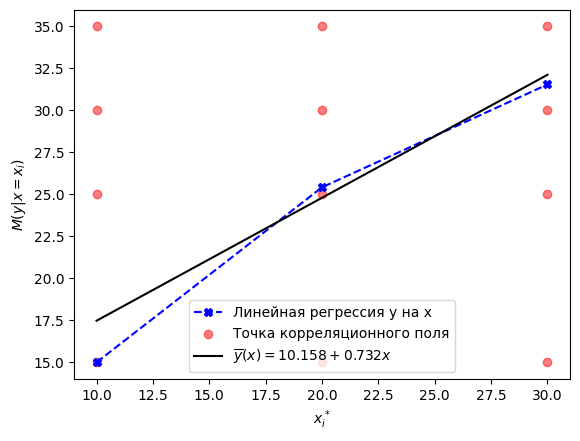

In [23]:
plt.plot(x, relative_means_y, marker='X', color='blue', linestyle='--', label=r'Линейная регрессия y на x')

label_added = False
for i in range(len(x)):
    for j in range(len(y)):
        if not label_added:
            plt.scatter(x[i], y[j], color='red', alpha=0.5, label=r'Точка корреляционного поля')
            label_added = True
        else:
            plt.scatter(x[i], y[j], color='red', alpha=0.5)


a = 295077 / 29050
b = 212613 / 290500
x_line = range(min(x), max(x) + 1)
y_line = [a + b * xi for xi in x_line]
plt.plot(x_line, y_line, color='black', label=r'$\overline{y}(x) = 10.158 + 0.732x$')
plt.xlabel(r'$x^*_i$')
plt.ylabel(r'$M(y|x=x_i)$')
plt.legend()
plt.show()